In [1]:
! pip install tensorflow-datasets

In [2]:
import tensorflow_datasets as tfds
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete3Y1H31/oxford_iiit_pet-train.tfrecord*...:…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete3Y1H31/oxford_iiit_pet-test.tfrecord*...: …

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [4]:
sample = next(iter(dataset['train'].take(1)))

# 获取图像和掩码
image, mask = sample['image'], sample['segmentation_mask']

# 打印图像和掩码的形状
print("Image shape:", image.shape)
print("Mask shape:", mask.shape)

Image shape: (500, 500, 3)
Mask shape: (500, 500, 1)


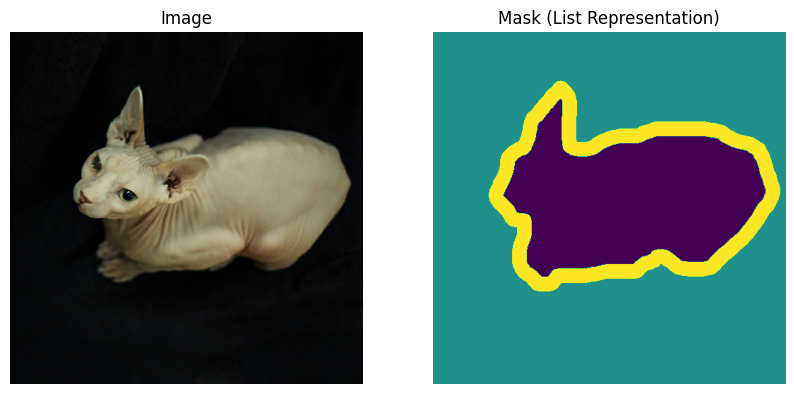

In [5]:
import matplotlib.pyplot as plt

# 將掩碼轉換為列表形式
mask_list = mask.numpy().tolist()

# 顯示圖像和掩碼
plt.figure(figsize=(10, 5))

# 顯示圖像
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Image')
plt.axis('off')

# 顯示掩碼的列表形式
plt.subplot(1, 2, 2)
plt.imshow(mask_list)  # 使用灰度色彩地圖來顯示掩碼
plt.title('Mask (List Representation)')
plt.axis('off')

plt.show()

In [7]:
import numpy as np

def dice_coefficient(y_true, y_pred, task_id, smooth=1):
    # 获取特定任务的标签
    y_true_task = (y_true == task_id).astype(np.float32)
    y_pred_task = (y_pred == task_id).astype(np.float32)

    # 计算特定任务的交集和并集
    intersection = np.sum(y_true_task * y_pred_task)
    union = np.sum(y_true_task) + np.sum(y_pred_task)

    # 计算特定任务的Dice系数
    dice = (2. * intersection + smooth) / (union + smooth)

    return dice

# 示例数据
y_true = np.array([[0, 1, 2], [0, 0, 1], [2, 2, 1]])
y_pred = np.array([[0, 1, 2], [0, 0, 1], [1, 1, 1]])

# 计算每个任务的Dice系数
for task_id in range(3):
    dice_task = dice_coefficient(y_true.flatten(), y_pred.flatten(), task_id)
    print(f"Dice系数（任务 {task_id}）: {dice_task}")
(1.0+0.7777777777777778+0.6)/3

Dice系数（任务 0）: 1.0
Dice系数（任务 1）: 0.7777777777777778
Dice系数（任务 2）: 0.6


0.7925925925925926

In [16]:
import numpy as np

def dice_coefficient(y_true, y_pred, smooth=1):
  dice = 0
  for task_id in list(np.unique(y_true)):
    y_true_task = (y_true == task_id).astype(np.float32)
    y_pred_task = (y_pred == task_id).astype(np.float32)
    intersection = np.sum(y_true_task * y_pred_task)
    union = np.sum(y_true_task) + np.sum(y_pred_task)
    dice += (2. * intersection + smooth) / (union + smooth)
  dice = dice/len(np.unique(y_true))

  return dice

# 示例数据
y_true = np.array([[0, 1, 2], [0, 0, 1], [2, 2, 1]])
y_pred = np.array([[0, 1, 2], [0, 0, 1], [1, 1, 1]])
dice_coefficient(y_true.flatten(), y_pred.flatten())
y_true

array([[0, 1, 2],
       [0, 0, 1],
       [2, 2, 1]])

In [57]:
len(mask_list)

500

In [9]:
import tensorflow_datasets as tfds
(train_ds_full, test_ds_full), metadata = tfds.load('oxford_iiit_pet', split=['train', 'test'], with_info=True, as_supervised=True)

# 获取每个数据集的样本数量
num_train_samples = metadata.splits['train'].num_examples
num_test_samples = metadata.splits['test'].num_examples
print(num_train_samples)
print(num_test_samples)

3680
3669


In [38]:
sample = next(iter(train_ds1.take(1)))
image, mask = sample['image'], sample['segmentation_mask']
print("Image shape:", image.shape)
print("Mask shape:", mask.shape)


Image shape: (500, 500, 3)
Mask shape: (500, 500, 1)


In [34]:
(train_ds1, train_ds2, val_ds), metadata = tfds.load(
    'oxford_iiit_pet',
    split=['train[:50%]', 'train[50%:]', 'test'],
    with_info=True,
)

In [ ]:
train_images = train_ds1

def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask
def load_image(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(
    datapoint['segmentation_mask'],
    (128, 128),
    method = tf.image.ResizeMethod.NEAREST_NEIGHBOR,
  )

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask
class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    # both use the same seed, so they'll make the same random changes.
    self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
    self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)

  def call(self, inputs, labels):
    inputs = self.augment_inputs(inputs)
    labels = self.augment_labels(labels)
    return inputs, labels

train_batches = (
    train_images
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))

base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

def unet_model(output_channels:int):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

OUTPUT_CLASSES = 3

model = unet_model(output_channels=OUTPUT_CLASSES)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# test

,file_name,image,label,segmentation_mask,species
0,Sphynx_158.jpg,,33 (Sphynx),,0 (Cat)
1,english_cocker_spaniel_135.jpg,,12 (english_cocker_spaniel),,1 (Dog)
2,British_Shorthair_181.jpg,,9 (British_Shorthair),,0 (Cat)
3,Siamese_161.jpg,,32 (Siamese),,0 (Cat)

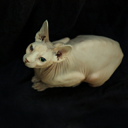
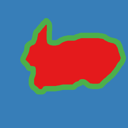
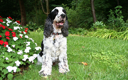
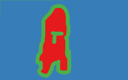
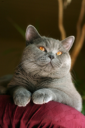
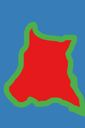
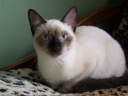
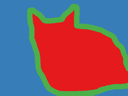

In [2]:
import tensorflow_datasets as tfds
ds, info = tfds.load('oxford_iiit_pet', split='train', with_info=True)

tfds.as_dataframe(ds.take(4), info)